# Fruit and Vegetable Classification Project

Note: workbook cells might not run due to multiple workbooks being consolidated and origin cells not retained.

## Workbook summary

- 1) Load Data
- 2) Size Audit
- 3) Find Images for performance test
    - We identified various images, such as the highest/lowest number of pixel images and high/low complexity images, in our dataset in order to perform a speed processing test.
- 4) Processing speed test: 200x200 pixels vs. 300x300 pixels
    - We conducted a simple timed test convolving images and found that the processing time was comparable so we decided to choose 300x300 for standard image size.
- 5) Remove Duplicates
    - We found that there were duplicates images within label，especially the test and validation sets contain exact duplicates images as train set. We took two step appraoch. 
      1. We discard the test and valdiation sets. 
      2. We leveraged a model difPy to find duplicates using criteria MSE < 0.01 and removed the lower resolution duplicate.
      3. We split our own valdiation and test set from the train set.
- 6) Resize all images to 300x300 and 32x32
    - The original images varied in size/resolution, were mostly rectangles, and on average more than 1200 pixels in both size and width. In order to standardize, we resized all the images to both 300x300 and 32x32. We chose multiple sizes in case we wanted to compare model performance downstream. We investigated cropping and padding images as an alternative, but ultimately decided on resizing since our manual checks showed we would not lose too much information by downsizing and the photos did not look too distorted after reshaping to a square. In addition, after resaving all the images, we would know all the images were of the same file type and therefore the CNN would perform properly and not mistakenly distinguish by file type.

## 1) Load Data

### Load Libraries

In [ ]:
import copy
import matplotlib.pyplot as plt 
import numpy as np
import os 
import random
import sys
import time

from sklearn.model_selection import train_test_split

from PIL import Image

from difPy import dif


### Load image sets

In [ ]:
train_images_dir = 'data/train'
validation_images_dir = 'data/validation'

image_source = "local"

def read_data(local_or_google = "local",data_directory = "data/",label_filter=[]):
    """
    Reads the data from the files, creates labels by file name

    Parameters: 
        data_dir (string): The name of a directory in which image data is located
        label_filters (list or array): Data labels to load, should match sub-folder names
        scale (int): The size to scale the loaded image data into a square matrix  
        max_count (int): The maximum data files to load
        subset (str): Either 'EQL' or 'PROP' depending on whether the data that is loaded  
                           per label should be equal or proportional to the total available. 
        pn_bacterial (boolean): Only relevant if PNEUMONIA is inclued in label_filters or no label_filters
                                are included. 
                                    If True, only loads Bacterial Pneumonia data. 
                                    If False, loads all Pneumonia data. 

    Output: 
        Tupel of lists (images, labels) where the former (images) is a list of matrix representations of the 
        scaled image data and the latter (labels) is a list of strings of the corresponding label of each 
        entry in the former (images) based on the sub-folder the image was loaded from. 
    """
    images = []
    labels = []
    loaded = {}

    if local_or_google == "local":
    #Crawl the data directory files and sub-directories...
        for dir_name, sub_dir_list, file_list in os.walk(data_directory):

            #Ignore anything in the actual directory itself (all images are in the sub-directories).
            if dir_name == data_directory:
                continue

            #The label will match the sub-folder name (root data folder ignored above.)
            label = os.path.basename(dir_name)
            
            if not label in label_filter:
                label_filter.append(label)
            print(f'Processing label: {label}')
                    
            for file_name in file_list:

                
                #Add label to loaded file dictinoary if it's not there already
                #(To keep track of how may files of this label have been loaded.)
                if label not in loaded: 
                     loaded[label] = 0

                #Start actual loading process.
                file_path = os.path.join(dir_name, file_name)

                # open in with structure to avoid memory leaks
                with Image.open(file_path) as f:
                    # copy impage into np array
                    image = np.array(f)

                    # append to output
                    images.append(image)

                    # set label to be the index of the label string in the label_filter list
                    label_index = label_filter.index(label)
                    labels.append(label_index)
                    
                loaded[label] += 1 

    #Print a summary of what's been loaded by label.
    for label in loaded: 
        print('%s: %s' % (label, loaded[label]))
    print('Total: %d' % sum(list(loaded.values())))
                    
    return(images, labels,label_filter)


# load validation data
print("Validation Set:")
val_images, val_labels, label_set = read_data (image_source,validation_images_dir)

In [ ]:
# Load training data
print("\nTraining Set:")
train_set_images, train_set_labels, label_set = read_data (image_source,train_images_dir,
                                               label_filter=label_set)


Training Set:
Processing label: apple
Processing label: banana
Processing label: beetroot
Processing label: bell pepper
Processing label: cabbage
Processing label: capsicum
Processing label: carrot
Processing label: cauliflower
Processing label: chilli pepper
Processing label: corn
Processing label: cucumber
Processing label: eggplant
Processing label: garlic
Processing label: ginger
Processing label: grapes
Processing label: jalepeno
Processing label: kiwi
Processing label: lemon
Processing label: lettuce
Processing label: mango
Processing label: onion
Processing label: orange
Processing label: paprika
Processing label: pear
Processing label: peas
Processing label: pineapple
Processing label: pomegranate
Processing label: potato
Processing label: raddish
Processing label: soy beans
Processing label: spinach
Processing label: sweetcorn
Processing label: sweetpotato
Processing label: tomato
Processing label: turnip
Processing label: watermelon
apple: 68
banana: 75
beetroot: 88
bell pep

### Train/test split 

In [ ]:
# split out 15 % of images for our test set
# data set comes with "test" images but they are a duplication of the validation set

train_images, test_images,train_labels, test_labels = train_test_split(
    train_set_images, train_set_labels, test_size=0.15, random_state=281)

print(len(train_images), len(train_labels), len(test_images), len(test_labels))

2647 2647 468 468


## 2) Size Audit

In [ ]:
# size audit
size_list = {}

for img in train_set_images:
    sz = f'{img.shape}'
    if sz not in size_list:
        size_list[sz] = 0
    size_list[sz] += 1

print('Image size \t count')
for sz in size_list:
    print('%s: %s' % (sz, size_list[sz]))

Image size 	 count
(2216, 2218, 3): 1
(1200, 1200, 3): 29
(249, 250, 3): 1
(800, 1200, 3): 43
(720, 1280, 3): 36
(1840, 1200, 3): 1
(1080, 986, 3): 1
(2400, 3200, 3): 3
(1650, 1275, 3): 1
(424, 283, 3): 2
(1000, 2000, 3): 11
(1198, 1200, 3): 1
(1083, 1200, 3): 1
(2000, 2000, 3): 3
(4496, 3968, 3): 1
(512, 512, 4): 5
(1600, 1200, 3): 21
(440, 1024, 3): 1
(440, 511, 3): 1
(2298, 3456, 3): 1
(900, 900, 3): 31
(2669, 3454, 4): 1
(1260, 1056, 3): 1
(2040, 1360, 3): 1
(1024, 1024, 3): 25
(1600, 1068, 3): 1
(900, 1200, 3): 25
(742, 1200, 3): 1
(3035, 4635, 3): 1
(2134, 5887, 3): 1
(610, 1118, 3): 1
(1587, 1119, 4): 1
(828, 1200, 3): 1
(1897, 3447, 3): 1
(296, 300, 3): 1
(866, 1300, 3): 1
(1080, 1080, 3): 1
(1676, 1340, 4): 1
(683, 1024, 3): 12
(2652, 5184, 3): 1
(1520, 720, 3): 1
(2656, 2500, 3): 1
(465, 826, 3): 1
(344, 400, 3): 1
(420, 520): 1
(382, 573, 3): 1
(546, 400, 3): 1
(4965, 4900, 3): 1
(1809, 1200, 3): 1
(1423, 2533, 4): 1
(496, 496, 4): 1
(1688, 2251, 3): 1
(1125, 1500, 3): 13
(1

(2079, 2079, 3): 1
(809, 1200, 3): 2
(486, 500, 3): 1
(768, 1154, 3): 2
(1096, 1359, 3): 1
(739, 814, 3): 1
(500, 550, 3): 1
(3323, 2209, 3): 1
(300, 375): 1
(286, 447, 3): 1
(960, 1098, 3): 1
(1674, 2181): 1
(310, 310, 3): 1
(1131, 1698, 3): 5
(1911, 1280, 3): 1
(1280, 1707, 3): 1
(635, 1000, 3): 1
(512, 872, 3): 1
(268, 400, 3): 1
(675, 948, 4): 1
(501, 900, 3): 1
(1047, 1514, 3): 1
(790, 1080, 3): 1
(220, 339, 4): 1
(315, 455, 3): 1
(867, 1300, 3): 1
(960, 1018, 3): 2
(900, 900, 4): 1
(1300, 1060, 3): 1
(956, 1300, 3): 2
(750, 500, 3): 3
(1167, 1300, 3): 1
(537, 450, 3): 1
(470, 338, 3): 1
(1014, 1300, 3): 1
(216, 304, 3): 1
(757, 1200, 3): 1
(904, 1600, 3): 1
(319, 450, 3): 1
(2688, 4048, 3): 1
(280, 347, 3): 1
(300, 300): 1
(776, 1440, 3): 1
(280, 390, 3): 2
(858, 674, 4): 1
(330, 660, 3): 1
(1159, 1300, 3): 1
(830, 650, 4): 1
(214, 236, 3): 1
(340, 720, 3): 1
(500, 339, 4): 1
(660, 1024, 3): 1
(257, 500, 3): 1
(531, 800, 3): 2
(1300, 1065, 3): 1
(1371, 1201, 3): 1
(202, 250, 4): 

In [ ]:
# size distribution
cutoffs = {100:0,200:0,300:0,500:0,1000:0,5000:0,10000:0}

for img in train_set_images:
    
    sz = img.shape
    
    h = sz[0]
    w = sz[1]

    for c in cutoffs:
        
        if h < c or w < c:
            cutoffs[c] += 1
            break
            
print(cutoffs)

{100: 0, 200: 19, 300: 156, 500: 437, 1000: 1268, 5000: 1234, 10000: 1}


## 3) Find Images for performance test

Max pixels:  12478


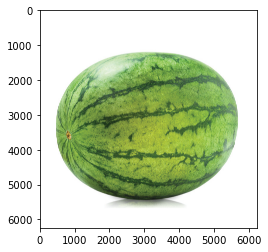

In [ ]:
# find the image with the highest number of pixels

max_pixel = [0,0]

for img in train_set_images:
    total_pixel = img.shape[0] + img.shape[1]
    if total_pixel > max_pixel[0]:
        max_pixel[0] = total_pixel
        max_pixel[1] = img
    
print('Max pixels: ',max_pixel[0])
plt.imshow(max_pixel[1])


Min pixels:  308


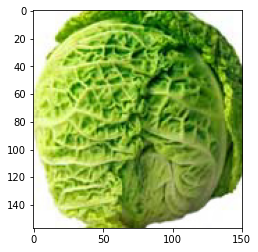

In [ ]:
# find the image with the smallest number of pixels

min_pixel = [99999,0]

for img in train_set_images:
    total_pixel = img.shape[0] + img.shape[1]
    if total_pixel < min_pixel[0]:
        min_pixel[0] = total_pixel
        min_pixel[1] = img
    
print('Min pixels: ',min_pixel[0])
plt.imshow(min_pixel[1])

## 4) Processing speed test: 200x200 pixels vs. 300x300 pixels

In [ ]:
import cv2

img = cv2.imread(train_images_dir + '/watermelon/Image_19.png')

# resize image by specifying custom width and height
resized = cv2.resize(img, (200, 200))

cv2.imwrite(train_images_dir + '/testing/test_1_200.jpg', resized)

# resize image by specifying custom width and height
resized = cv2.resize(img, (300, 300))

cv2.imwrite(train_images_dir + '/testing/test_1_300.jpg', resized)

#---------------------------------------------------------

img = cv2.imread(train_images_dir + '/cabbage/Image_72.jpg')

# resize image by specifying custom width and height
resized = cv2.resize(img, (200, 200))

cv2.imwrite(train_images_dir + '/testing/test_2_200.jpg', resized)

# resize image by specifying custom width and height
resized = cv2.resize(img, (300, 300))

cv2.imwrite(train_images_dir + '/testing/test_2_300.jpg', resized)

#---------------------------------------------------------

img = cv2.imread(train_images_dir + '/apple/Image_50.jpg')

# resize image by specifying custom width and height
resized = cv2.resize(img, (200, 200))

cv2.imwrite(train_images_dir + '/testing/test_3_200.jpg', resized)

# resize image by specifying custom width and height
resized = cv2.resize(img, (300, 300))

cv2.imwrite(train_images_dir + '/testing/test_3_300.jpg', resized)

#---------------------------------------------------------

img = cv2.imread(train_images_dir + '/apple/Image_33.jpg')

# resize image by specifying custom width and height
resized = cv2.resize(img, (200, 200))

cv2.imwrite(train_images_dir + '/testing/test_4_200.jpg', resized)

# resize image by specifying custom width and height
resized = cv2.resize(img, (300, 300))

cv2.imwrite(train_images_dir + '/testing/test_4_300.jpg', resized)




True

In [ ]:
from skimage import color
from skimage import io
import numpy as np
from scipy import ndimage
import matplotlib
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.color import rgb2gray, rgba2rgb
import timeit
from IPython.display import Image
from IPython.display import display

Runtime 200x200:  0.003802999999606982
Runtime 300x300:  0.004984799999874667


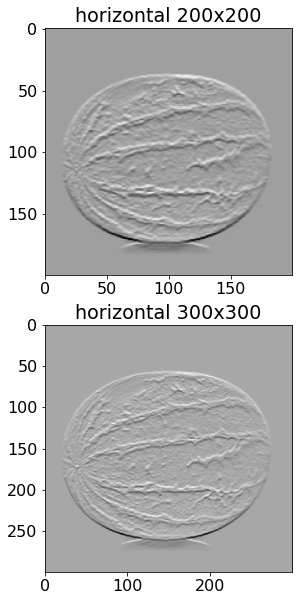

In [ ]:
# run test against resized largest image (200x200 vs 300x300)

def time_test(img_str):
    
    k_h = np.array([[-1,-1,-1],
                [ 0, 0, 0],
                [ 1, 1, 1]])

    in_img = color.rgb2gray(io.imread(train_images_dir + img_str))
    out_img = ndimage.convolve(in_img, k_h, mode='reflect')
    
    return out_img
    
starttime = timeit.default_timer()
img1 = time_test('/testing/test_1_200.jpg')
print("Runtime 200x200: ", timeit.default_timer() - starttime)

starttime = timeit.default_timer()
img2 = time_test('/testing/test_1_300.jpg')
print("Runtime 300x300: ", timeit.default_timer() - starttime)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

# Display target image
axes[0].imshow(img1, cmap=plt.cm.gray)
axes[0].set_title('horizontal 200x200')

axes[1].imshow(img2, cmap=plt.cm.gray)
axes[1].set_title('horizontal 300x300')

plt.show()

Runtime 200x200:  0.004060700000991346
Runtime 300x300:  0.007318099998883554


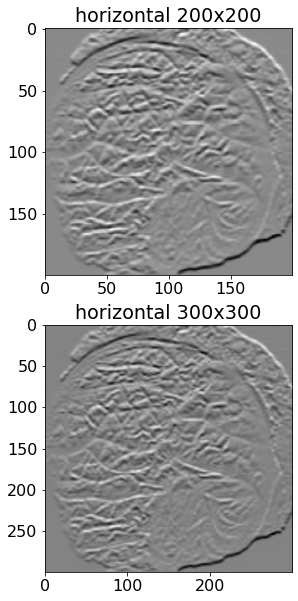

In [ ]:
# run test against resized smallest image (200x200 vs 300x300)

def time_test(img_str):
    
    k_h = np.array([[-1,-1,-1],
                [ 0, 0, 0],
                [ 1, 1, 1]])

    in_img = color.rgb2gray(io.imread(train_images_dir + img_str))
    out_img = ndimage.convolve(in_img, k_h, mode='reflect')
    
    return out_img
    
starttime = timeit.default_timer()
img1 = time_test('/testing/test_2_200.jpg')
print("Runtime 200x200: ", timeit.default_timer() - starttime)

starttime = timeit.default_timer()
img2 = time_test('/testing/test_2_300.jpg')
print("Runtime 300x300: ", timeit.default_timer() - starttime)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

# Display target image
axes[0].imshow(img1, cmap=plt.cm.gray)
axes[0].set_title('horizontal 200x200')

axes[1].imshow(img2, cmap=plt.cm.gray)
axes[1].set_title('horizontal 300x300')

plt.show()

Runtime 200x200:  0.005305399999997462
Runtime 300x300:  0.010630900000251131


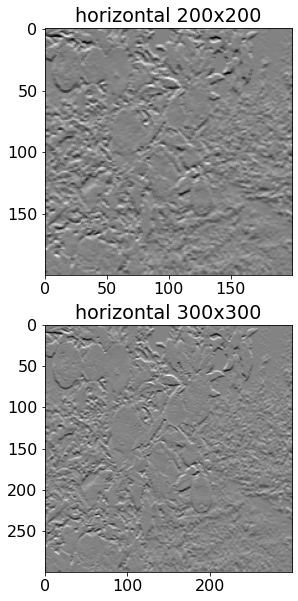

In [ ]:
# run test against high complexity image (200x200 vs 300x300)

def time_test(img_str):
    
    k_h = np.array([[-1,-1,-1],
                [ 0, 0, 0],
                [ 1, 1, 1]])

    in_img = color.rgb2gray(io.imread(train_images_dir + img_str))
    out_img = ndimage.convolve(in_img, k_h, mode='reflect')
    
    return out_img
    
starttime = timeit.default_timer()
img1 = time_test('/testing/test_3_200.jpg')
print("Runtime 200x200: ", timeit.default_timer() - starttime)

starttime = timeit.default_timer()
img2 = time_test('/testing/test_3_300.jpg')
print("Runtime 300x300: ", timeit.default_timer() - starttime)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

# Display target image
axes[0].imshow(img1, cmap=plt.cm.gray)
axes[0].set_title('horizontal 200x200')

axes[1].imshow(img2, cmap=plt.cm.gray)
axes[1].set_title('horizontal 300x300')

plt.show()

Runtime 200x200:  0.004267100001015933
Runtime 300x300:  0.006175700000312645


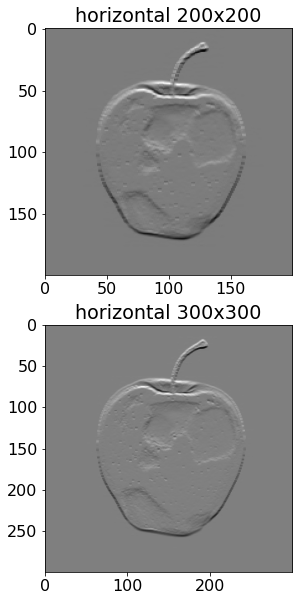

In [ ]:
# run test against low complexity image (200x200 vs 300x300)

def time_test(img_str):
    
    k_h = np.array([[-1,-1,-1],
                [ 0, 0, 0],
                [ 1, 1, 1]])

    in_img = color.rgb2gray(io.imread(train_images_dir + img_str))
    out_img = ndimage.convolve(in_img, k_h, mode='reflect')
    
    return out_img
    
starttime = timeit.default_timer()
img1 = time_test('/testing/test_4_200.jpg')
print("Runtime 200x200: ", timeit.default_timer() - starttime)

starttime = timeit.default_timer()
img2 = time_test('/testing/test_4_300.jpg')
print("Runtime 300x300: ", timeit.default_timer() - starttime)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

# Display target image
axes[0].imshow(img1, cmap=plt.cm.gray)
axes[0].set_title('horizontal 200x200')

axes[1].imshow(img2, cmap=plt.cm.gray)
axes[1].set_title('horizontal 300x300')

plt.show()

## 5) Remove Duplicates

In [ ]:
from difPy import dif
# search = dif(train_images_dir+"/watermelon", test_images_dir+"/watermelon", similarity="high")

In [ ]:
search_val = dif(train_images_dir+"/watermelon", validation_images_dir+"/watermelon", similarity="high")

Found 14 images with one or more duplicate/similar images in 11.1562 seconds.


In [ ]:
search.result

{'Image_1.jpg': {'duplicates': ['drive/MyDrive/w281-cv-fruit-project/data/test/watermelon/Image_1.jpg'],
  'location': 'drive/MyDrive/w281-cv-fruit-project/data/train/watermelon/Image_1.jpg'},
 'Image_10.jpg': {'duplicates': ['drive/MyDrive/w281-cv-fruit-project/data/test/watermelon/Image_10.jpg'],
  'location': 'drive/MyDrive/w281-cv-fruit-project/data/train/watermelon/Image_10.jpg'},
 'Image_100.jpg': {'duplicates': ['drive/MyDrive/w281-cv-fruit-project/data/test/watermelon/Image_4.jpg'],
  'location': 'drive/MyDrive/w281-cv-fruit-project/data/train/watermelon/Image_100.jpg'},
 'Image_2.jpg': {'duplicates': ['drive/MyDrive/w281-cv-fruit-project/data/test/watermelon/Image_2.jpg'],
  'location': 'drive/MyDrive/w281-cv-fruit-project/data/train/watermelon/Image_2.jpg'},
 'Image_3.jpg': {'duplicates': ['drive/MyDrive/w281-cv-fruit-project/data/test/watermelon/Image_3.jpg'],
  'location': 'drive/MyDrive/w281-cv-fruit-project/data/train/watermelon/Image_3.jpg'},
 'Image_4.jpg': {'duplicates

In [ ]:
search.stats

{'directory_1': 'drive/MyDrive/w281-cv-fruit-project/data/train/watermelon',
 'directory_2': 'drive/MyDrive/w281-cv-fruit-project/data/test/watermelon',
 'duration': {'end_date': '2022-07-03',
  'end_time': '23:59:43',
  'seconds_elapsed': 50.6031,
  'start_date': '2022-07-03',
  'start_time': '23:58:52'},
 'similarity_grade': 'normal',
 'similarity_mse': 200,
 'total_dupl_sim_found': 14,
 'total_images_searched': 94}

### Compare train vs validation and train vs test set

In [ ]:
for i in range(36):
  category = category_list[i]
  train_path = train_images_dir+'/'+ category
  test_path = test_images_dir+'/'+ category
  validation_path = validation_images_dir+'/'+ category

  search_test = dif(train_path, test_path, similarity="high")
  search_validation = dif(train_path, validation_path, similarity="high")

  print(category)
  print("Num of samples in test:\t" + str(len(os.listdir(test_path))) + '.\t\tNum of samples of duplicates (train vs test):\t'+ str(search_test.stats['total_dupl_sim_found']))
  print("Num of samples in valdiation:\t" + str(len(os.listdir(validation_path))) + '.\t\tNum of samples of duplicates (train vs validation):\t'+ str(search_validation.stats['total_dupl_sim_found']))
  print('--------------------------------------------------------')

Found 6 images with one or more duplicate/similar images in 4.9576 seconds.
Found 6 images with one or more duplicate/similar images in 4.9044 seconds.
apple
Num of samples in test:	10.		Num of samples of duplicates (train vs test):	6
Num of samples in valdiation:	10.		Num of samples of duplicates (train vs validation):	6
--------------------------------------------------------
Found 20 images with one or more duplicate/similar images in 4.257 seconds.
Found 20 images with one or more duplicate/similar images in 4.2345 seconds.
beetroot
Num of samples in test:	10.		Num of samples of duplicates (train vs test):	20
Num of samples in valdiation:	10.		Num of samples of duplicates (train vs validation):	20
--------------------------------------------------------
Found 12 images with one or more duplicate/similar images in 15.4654 seconds.
Found 10 images with one or more duplicate/similar images in 11.2474 seconds.
bell pepper
Num of samples in test:	10.		Num of samples of duplicates (train

IndexError: ignored

### Find duplicates in train set

In [ ]:
# !cp -r drive/MyDrive/w281-cv-fruit-project/data/train drive/MyDrive/w281-cv-fruit-project/data/train_v2

In [ ]:
len(os.listdir('drive/MyDrive/w281-cv-fruit-project/data/train_v2'))

36

Check whether train folder of each category contain duplicate. 

In [ ]:
for i in range(36):
  category = category_list[i]
  train_path = 'drive/MyDrive/w281-cv-fruit-project/data/train_v2/'+ category
  print(category)
  search_train = dif(train_path, similarity="high")
  print(search_train.result)
  print('--------------------------------------------------------')

apple
Found 0 images with one or more duplicate/similar images in 5.0706 seconds.
{}
--------------------------------------------------------
beetroot
Found 10 images with one or more duplicate/similar images in 5.4347 seconds.
{'Image_10.jpg': {'location': 'drive/MyDrive/w281-cv-fruit-project/data/train_v2/beetroot/Image_10.jpg', 'duplicates': ['drive/MyDrive/w281-cv-fruit-project/data/train_v2/beetroot/Image_100.jpg']}, 'Image_1.jpg': {'location': 'drive/MyDrive/w281-cv-fruit-project/data/train_v2/beetroot/Image_1.jpg', 'duplicates': ['drive/MyDrive/w281-cv-fruit-project/data/train_v2/beetroot/Image_91.jpg']}, 'Image_3.jpg': {'location': 'drive/MyDrive/w281-cv-fruit-project/data/train_v2/beetroot/Image_3.jpg', 'duplicates': ['drive/MyDrive/w281-cv-fruit-project/data/train_v2/beetroot/Image_93.jpg']}, 'Image_2.jpg': {'location': 'drive/MyDrive/w281-cv-fruit-project/data/train_v2/beetroot/Image_2.jpg', 'duplicates': ['drive/MyDrive/w281-cv-fruit-project/data/train_v2/beetroot/Image_92.

### Manual spot check. 

In [ ]:
train_path = 'drive/MyDrive/w281-cv-fruit-project/data/train/'+ 'spinach'
search_train = dif(train_path, similarity="high")
search_train.result


Found 7 images with one or more duplicate/similar images in 5.9414 seconds.


{'Image_1.jpg': {'duplicates': ['drive/MyDrive/w281-cv-fruit-project/data/train/spinach/Image_94.jpg'],
  'location': 'drive/MyDrive/w281-cv-fruit-project/data/train/spinach/Image_1.jpg'},
 'Image_100.jpg': {'duplicates': ['drive/MyDrive/w281-cv-fruit-project/data/train/spinach/Image_7.jpg'],
  'location': 'drive/MyDrive/w281-cv-fruit-project/data/train/spinach/Image_100.jpg'},
 'Image_2.jpg': {'duplicates': ['drive/MyDrive/w281-cv-fruit-project/data/train/spinach/Image_95.jpg'],
  'location': 'drive/MyDrive/w281-cv-fruit-project/data/train/spinach/Image_2.jpg'},
 'Image_3.jpg': {'duplicates': ['drive/MyDrive/w281-cv-fruit-project/data/train/spinach/Image_96.jpg'],
  'location': 'drive/MyDrive/w281-cv-fruit-project/data/train/spinach/Image_3.jpg'},
 'Image_4.jpg': {'duplicates': ['drive/MyDrive/w281-cv-fruit-project/data/train/spinach/Image_97.jpg'],
  'location': 'drive/MyDrive/w281-cv-fruit-project/data/train/spinach/Image_4.jpg'},
 'Image_5.jpg': {'duplicates': ['drive/MyDrive/w281-

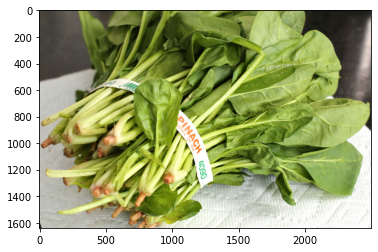

In [ ]:
im1 = plt.imread('drive/MyDrive/w281-cv-fruit-project/data/train/spinach/Image_94.jpg')
im1_dup = plt.imread('drive/MyDrive/w281-cv-fruit-project/data/train/spinach/Image_1.jpg')
plt.imshow(im1)

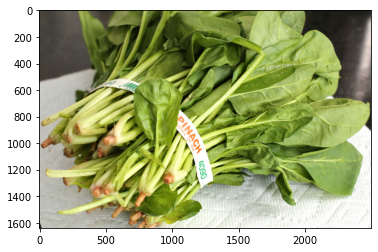

In [ ]:
plt.imshow(im1_dup)

### Remove duplicates from train
The lower resolution duplicate images that were found by difPy are deleted from the folder.

In [ ]:
for i in range(36):
  category = category_list[i]
  train_path = 'drive/MyDrive/w281-cv-fruit-project/data/train_v2/'+ category
  print(category)
  search_train = dif(train_path, similarity="high", delete=True, silent_del=True)
  # print(search_train.result)
  print('--------------------------------------------------------')

apple
Found 0 images with one or more duplicate/similar images in 5.3575 seconds.
--------------------------------------------------------
beetroot
Found 10 images with one or more duplicate/similar images in 5.504 seconds.

Deleted file: drive/MyDrive/w281-cv-fruit-project/data/train_v2/beetroot/Image_93.jpg
Deleted file: drive/MyDrive/w281-cv-fruit-project/data/train_v2/beetroot/Image_91.jpg
Deleted file: drive/MyDrive/w281-cv-fruit-project/data/train_v2/beetroot/Image_100.jpg
Deleted file: drive/MyDrive/w281-cv-fruit-project/data/train_v2/beetroot/Image_92.jpg
Deleted file: drive/MyDrive/w281-cv-fruit-project/data/train_v2/beetroot/Image_97.jpg
Deleted file: drive/MyDrive/w281-cv-fruit-project/data/train_v2/beetroot/Image_96.jpg
Deleted file: drive/MyDrive/w281-cv-fruit-project/data/train_v2/beetroot/Image_95.jpg
Deleted file: drive/MyDrive/w281-cv-fruit-project/data/train_v2/beetroot/Image_99.jpg
Deleted file: drive/MyDrive/w281-cv-fruit-project/data/train_v2/beetroot/Image_98.jpg


Confirm no duplciate within the train_v2 folder. 

In [ ]:
for i in range(36):
  category = category_list[i]
  train_path = 'drive/MyDrive/w281-cv-fruit-project/data/train_v2/'+ category
  print(category)
  search_train = dif(train_path, similarity="high")
  print('--------------------------------------------------------')

apple
Found 0 images with one or more duplicate/similar images in 5.5584 seconds.
--------------------------------------------------------
beetroot
Found 0 images with one or more duplicate/similar images in 4.4384 seconds.
--------------------------------------------------------
bell pepper
Found 3 images with one or more duplicate/similar images in 6.9394 seconds.
--------------------------------------------------------
banana
Found 0 images with one or more duplicate/similar images in 4.58 seconds.
--------------------------------------------------------
cucumber
Found 0 images with one or more duplicate/similar images in 6.2702 seconds.
--------------------------------------------------------
eggplant
Found 0 images with one or more duplicate/similar images in 4.8432 seconds.
--------------------------------------------------------
chilli pepper
Found 0 images with one or more duplicate/similar images in 4.1812 seconds.
--------------------------------------------------------
cabba

## 6) Resize all images to 300x300 and 32x32

In [ ]:
# Importing Image class from PIL module
from PIL import Image
from os import path

in_path = 'drive/My Drive/281 Final Project/data/train_v2/'
out_path = 'drive/My Drive/281 Final Project/data/resized_32x32/'

if path.exists(out_path) == False:
  os.mkdir(out_path)

for category in os.listdir(in_path):

  for img in os.listdir(in_path + category):

    with Image.open(in_path + category + '/' + img) as im:

        file, ext = os.path.splitext(img)

        print(file, ext)

        # width, height = im.size
        
        # # Setting the points for cropped image
        # left = 6
        # top = height / 4
        # right = 174
        # bottom = 3 * height / 4
        
        # # Cropped image of above dimension
        # # (It will not change original image)
        # im1 = im.crop((left, top, right, bottom))
        newsize = (32, 32)
        im1 = im.resize(newsize)

        full_out_path = out_path + category + '/'

        if path.exists(full_out_path) == False:
          os.mkdir(full_out_path)

        if im1.mode != 'RGB':
          im1 = im1.convert('RGB')

        im1.save(full_out_path + file + '.jpg', 'JPEG')